In [1]:
# import libraries 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set_theme()

plt.rcParams['figure.figsize'] = [10, 8]

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
###################################

#import fluospec

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 2. Generative model:
Theory describes that in the absence of external broadening mechanisms,  the intensity profile of the fluorescence of atoms and molecules is given by a Lorentzian line shape:
$$ I(\omega) = A \frac{\Gamma^2/4}{(\omega - \omega_0)^2 + \Gamma^2/4}$$
where $A$ is the amplitude, $\omega_0$ is the center frequency of the fluorescence and $\Gamma$ is the decay rate of the transition (also the full width at half maximum).

In our data, we have a background that is linear with the frequency which can be modeled by a linear equation:
$$ I_b(\omega) = m\omega + b$$
such that the full model is 
$$I_T(\omega) = I(\omega) + I_b(\omega) = A \frac{\Gamma^2/4}{(\omega - \omega_0)^2 + \Gamma^2/4} + (m\omega + b)$$

Noise on the camera is fairly complex, but data points are averaged, so that the noise on the camera can be characterized as Gaussian with $\sigma$ = 0.2, thus:
$$ y_i \sim \text{normal}(\mu_i = I_T(\omega_i) ,\sigma_i = 0.2)$$

In addition to the lineshape model, we can add a parameter that accounts for the power broadening of the lineshape: 

$$I_T(\omega) = I(\omega) + I_b(\omega) = A \frac{\Gamma^2/4}{(\omega - \omega_0)^2 + \Gamma^2/4\left(1+\frac{I}{I_{\text{sat}}}\right)} + (m\omega + b)$$

Lastly the priors for all our parameters will be uniform: 
$$A \sim \text{gamma}(\mu = 5,\sigma = 1)$$

$$\omega_0 \sim \text{gamma}(\mu = 20,\sigma = 4)$$

$$\Gamma \sim \text{gamma}(\mu = 5,\sigma = 1)$$

$$ \frac{I}{I_{\text{sat}}} \sim \text{gamma}(\mu = 0.5,\sigma = 0.1)$$

$$m \sim \text{normal}(\mu = 0.05,\sigma = 0.01)$$

$$b \sim \text{normal}(\mu = 1,\sigma = 0.2)$$

Thus the full statistical model is:
$$ \boxed{y_i \sim \text{normal}(\mu_i = I_T(\omega_i) ,\sigma_i = 0.2)\\A \sim \text{gamma}(5,1) \\\omega_0 \sim \text{gamma}(20,4)\\\Gamma \sim \text{gamma}(5,1)\\\frac{I}{I_{\text{sat}}} \sim \text{gamma}(0.5, 0.1)\\m \sim \text{normal}(0.05,0.1)\\b \sim \text{normal}(2,0.4)}$$

We use normal priors since our bounds aren't well defined.

# 3. Simulation of data:
We begin by defining a function for our Lorentzian line shape:

In [2]:
def lorentzian(w: np.ndarray,
               A: float,
               w0: float,
               gamma: float,
               intensity_ratio: float
     ) -> np.ndarray: 
    """
    Calculates the Lorentzian line shape 
    
    Parameters:
    -----------
    A : float
        Amplitude of line 
    w : ndarray
        Frequency
    w0 : ndarray
        Central frequency
    gamma : ndarray
        The decay rate of the transition. 
        Also the full width at half maximum
    intensity_ratio: float
        The ratio between the laser intensity and saturation intensity
    Returns
    -------
    ndarray:
        array of the Lorentzian of the parameters  
    """
        
    lorentzian = A*(gamma**2/4)/((w - w0)**2 + (gamma**2/4)*(1+intensity_ratio))
    return lorentzian 

In [3]:
w_sim = np.linspace(0,40,250)
w0_sim = 20
A_sim = 2
gamma_sim = 5
intensity_ratio = 0.5

m_sim = .05
b_sim = 2

uncertainty = .2

foreground = lorentzian(w_sim, A_sim, w0_sim, gamma_sim, intensity_ratio)

noise = np.random.normal(0, uncertainty, len(w_sim))
background = noise + (m_sim*w_sim + b_sim)

sim_data = (foreground + background)

In [4]:
# define the data 
data = pd.DataFrame({'w': w_sim,
                     'I': sim_data,
                     'sigma_I': uncertainty})
w = data.w
I = data.I
sigma_I = data.sigma_I

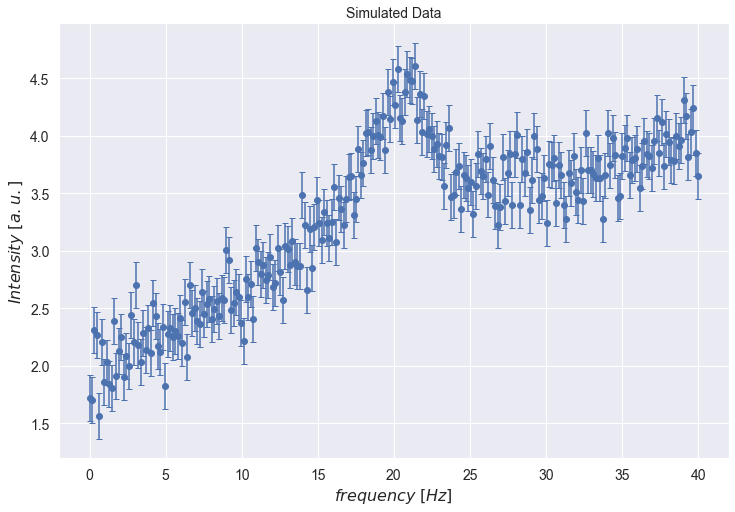

In [5]:
# data.plot(x='w', y='I', kind='scatter', yerr=uncertainty);
plt.figure(figsize=(12,8))
plt.errorbar(w, I, yerr=sigma_I, fmt='o', capsize=3)
plt.xlabel('$frequency \ [Hz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, intensity_ratio, gamma, w0, A]


Sampling 4 chains for 7_000 tune and 2_000 draw iterations (28_000 + 8_000 draws total) took 55 seconds.
C:\Users\Derick\AppData\Local\Temp\ipykernel_8512\3821642292.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


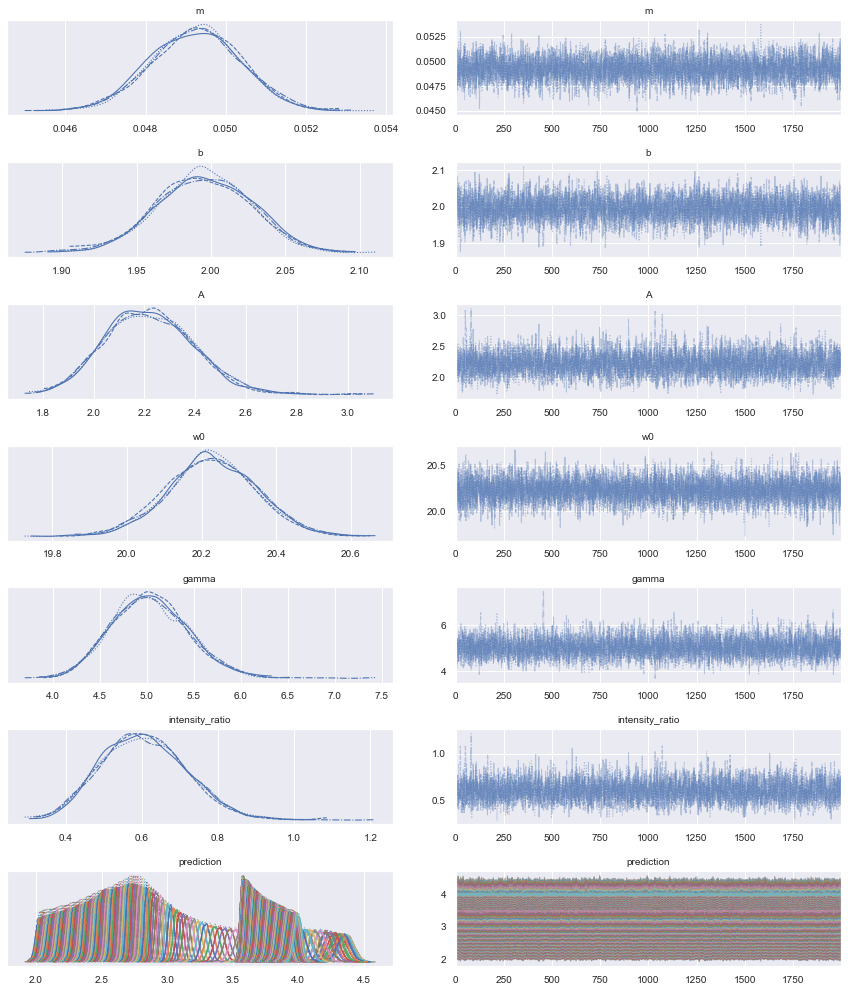

In [6]:
spectroscopy_model = pm.Model()

w = np.array(w)

with spectroscopy_model:
    A = pm.Gamma('A', mu = 5, sigma = 1)
    w0 = pm.Gamma('w0', mu = 20, sigma = 4)
    gamma = pm.Gamma('gamma', mu = 5, sigma = 5)
    intensity_ratio = pm.Gamma('intensity_ratio', mu = 0.5, sigma = 0.1)
    
    m = pm.Normal('m', 0.05, 0.01)
    b = pm.Normal('b', 2, 0.4)
    
    peak = lorentzian(w, A, w0, gamma, intensity_ratio)
    line = m*w + b
        
    I_pred = pm.Deterministic('prediction', line + peak)
 
    measurements = pm.Normal('I_model', mu=I_pred, sigma=uncertainty, observed=I)

    #trace = pm.sample(start=pm.find_MAP(), return_inferencedata=True, tune=5000, draws=2000)
    trace = pm.sample(return_inferencedata=True, tune=7000, draws=2000)
    az.plot_trace(trace)
    plt.tight_layout()

posterior = trace.posterior.to_dataframe()

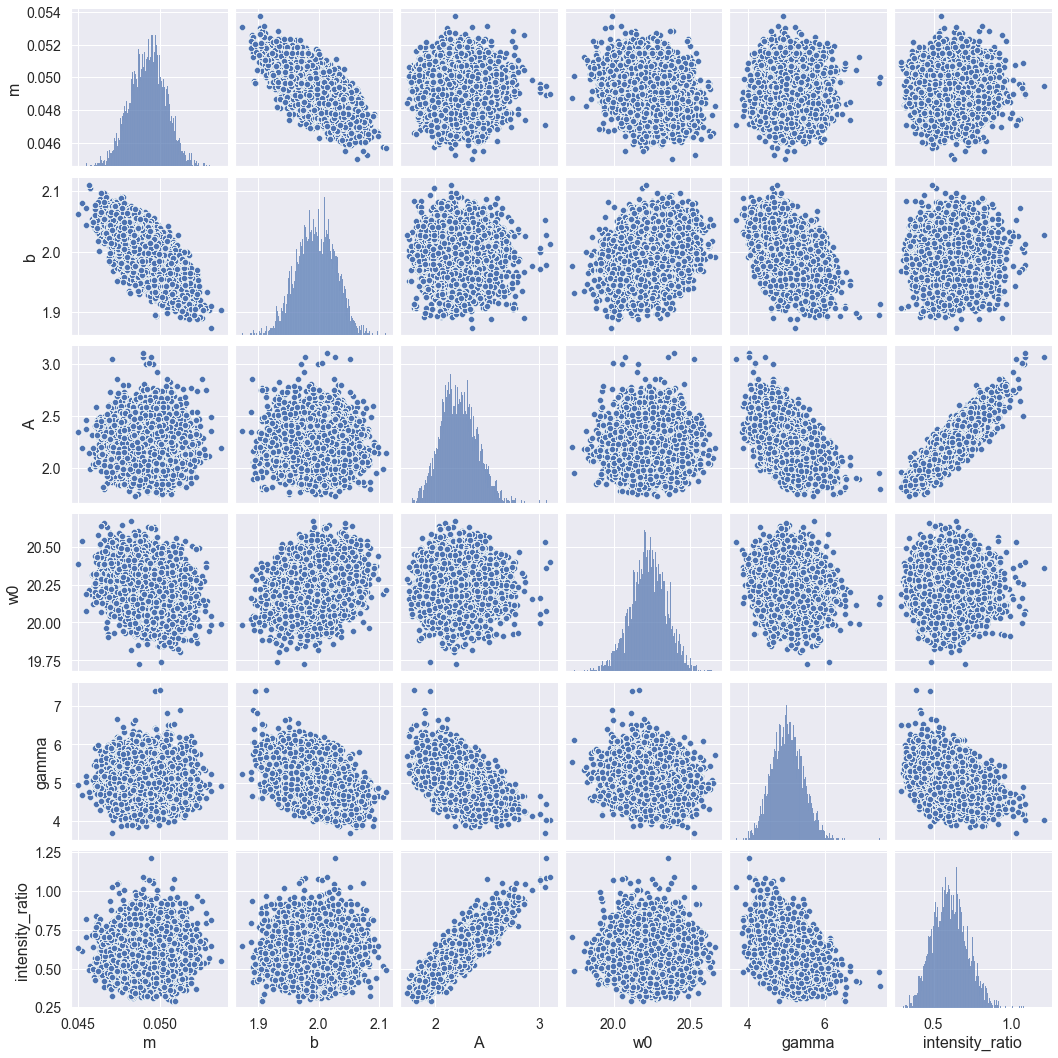

In [7]:
sns.pairplot(posterior.drop('prediction', axis=1))

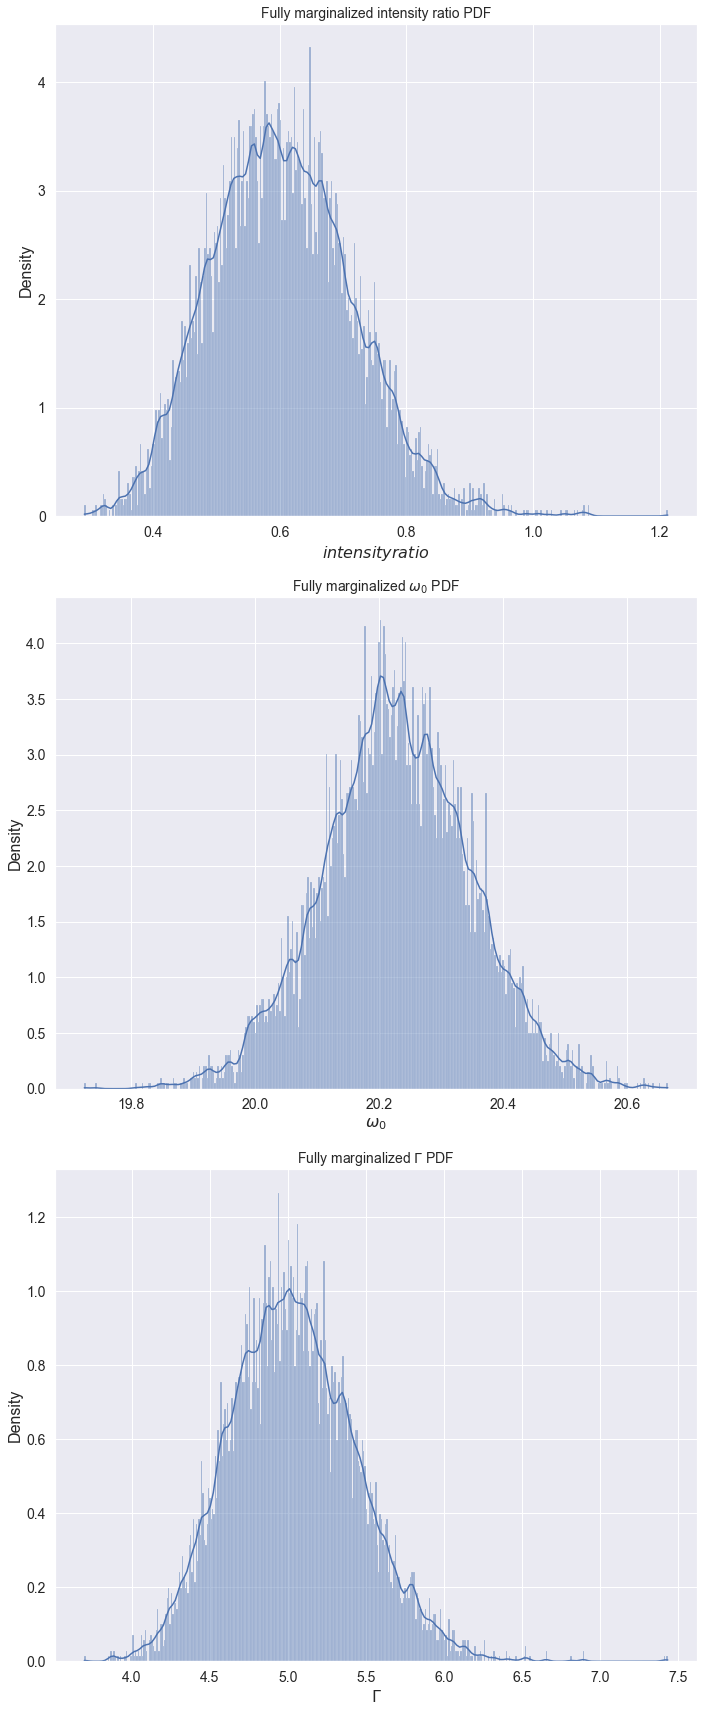

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 24))

marg_intensity_ratio = sns.histplot(posterior.intensity_ratio,
                      fill=True, stat="density",
                      kde=True,
                      ax=ax1
                     )
marg_intensity_ratio.set(xlabel='$intensity ratio$',
           title='Fully marginalized intensity ratio PDF'
           );


marg_w0 = sns.histplot(posterior.w0,
                       fill=True, stat="density",
                       kde=True,
                       ax=ax2
                      )
marg_w0.set(xlabel='$\omega_0$',
            title='Fully marginalized $\omega_0$ PDF'
            );

marg_gamma = sns.histplot(posterior.gamma,
                          fill=True, stat="density",
                          kde=True,
                          ax=ax3
                         )
marg_gamma.set(xlabel='$\Gamma$',
               title='Fully marginalized $\Gamma$ PDF'
               );

plt.tight_layout()


In [9]:
az.summary(trace, hdi_prob=.95)[0:6]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.049,0.001,0.047,0.052,0.000,0.000,4808.0,4717.0,1.0
b,1.995,0.032,1.930,2.053,0.000,0.000,4282.0,4759.0,1.0
A,2.221,0.174,1.890,2.554,0.003,0.002,3677.0,4477.0,1.0
w0,20.229,0.120,19.985,20.453,0.002,0.001,6223.0,5608.0,1.0
gamma,5.033,0.408,4.274,5.847,0.006,0.004,4349.0,4851.0,1.0
intensity_ratio,0.605,0.112,0.398,0.822,0.002,0.001,3863.0,4389.0,1.0
